# Trading Strategy Visualization Dashboard

This notebook provides comprehensive visualization of trading strategies including:
- Individual trade analysis with candlestick charts
- Buy/Sell signals with arrows
- SMA indicator lines
- Trade performance metrics

## Instructions:
1. Run all cells to set up the environment
2. Use the `visualize_trade(index)` function to view specific trades
3. Trade index starts from 1 (first trade = index 1)

In [317]:
# Configuration Constants for Visualization
# Modify these values to customize the appearance of all charts

# Chart Settings
CHART_WIDTH = 15
CHART_HEIGHT = 10
CANDLESTICK_WIDTH = 0.6
CANDLES_BEFORE_AFTER = 10  # Number of candles to show before/after trade

# Colors
BULLISH_COLOR = 'green'
BEARISH_COLOR = 'red'
SMA_20_COLOR = 'orange'
SMA_50_COLOR = 'purple'
ENTRY_BUY_COLOR = 'green'
ENTRY_SELL_COLOR = 'red'
EXIT_COLOR = 'red'
STOP_LOSS_COLOR = 'red'
VOLUME_ALPHA = 0.6
GRID_ALPHA = 0.3

# SMA Settings
SMA_SHORT_PERIOD = 20
SMA_LONG_PERIOD = 50
SMA_LINE_WIDTH = 2

# Signal Markers
ENTRY_MARKER_SIZE = 200
EXIT_MARKER_SIZE = 200
BUY_MARKER = '^'  # Triangle up
SELL_MARKER = 'v'  # Triangle down

# Text and Labels
TITLE_FONT_SIZE = 14
LABEL_FONT_SIZE = 12
LEGEND_LOCATION = 'upper left'

# Analytics Chart Settings
ANALYTICS_FIGURE_SIZE = (15, 10)
HISTOGRAM_BINS = 30
HISTOGRAM_ALPHA = 0.7
HISTOGRAM_COLOR = 'lightblue'

# File Paths (relative to notebook)
TRADES_DATA_PATH = '../data/result/backtest_output.csv'
PRICE_DATA_PATH = '../data/raw/btcusdt_1h.csv'

print("📋 Configuration constants loaded successfully!")
print(f"Chart size: {CHART_WIDTH}x{CHART_HEIGHT}")
print(f"SMA periods: {SMA_SHORT_PERIOD} and {SMA_LONG_PERIOD}")
print(f"Candles around trade: ±{CANDLES_BEFORE_AFTER}")
print("🎨 You can modify these constants to customize all visualizations")

📋 Configuration constants loaded successfully!
Chart size: 15x10
SMA periods: 20 and 50
Candles around trade: ±10
🎨 You can modify these constants to customize all visualizations


In [318]:
%pip install nbformat==4.2.0

Note: you may need to restart the kernel to use updated packages.


In [319]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Matplotlib settings for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully!")
print("Using matplotlib for stable notebook visualization")

✅ Libraries imported successfully!
Using matplotlib for stable notebook visualization


In [320]:
# Load data
print("Loading trading data...")

# Load backtest results using configuration path
trades_df = pd.read_csv(TRADES_DATA_PATH)
trades_df['entry_date'] = pd.to_datetime(trades_df['entry_date'])
trades_df['exit_date'] = pd.to_datetime(trades_df['exit_date'])

# Load raw price data using configuration path
price_data = pd.read_csv(PRICE_DATA_PATH)
price_data['datetime'] = pd.to_datetime(price_data['datetime'])
price_data = price_data.sort_values('datetime').reset_index(drop=True)

print(f"Loaded {len(trades_df)} trades")
print(f"Loaded {len(price_data)} price candles")
print(f"Price data range: {price_data['datetime'].min()} to {price_data['datetime'].max()}")

# Check if we have fee data (new format) or old format
if 'net_profit_loss' in trades_df.columns:
    print("✅ Fee-aware trading data detected")
    print(f"Total fees in all trades: ${trades_df['total_fees'].sum():.2f}")
    # Use net profit/loss for analysis
    trades_df['profit_loss'] = trades_df['net_profit_loss']
    trades_df['profit_loss_pct'] = trades_df['net_profit_loss_pct']
else:
    print("⚠️  Using legacy data format (no fee information)")

# Display first few trades
print("\nFirst 5 trades:")
display(trades_df.head())

Loading trading data...


Loaded 113 trades
Loaded 4895 price candles
Price data range: 2025-01-01 00:00:00 to 2025-07-23 22:00:00
✅ Fee-aware trading data detected
Total fees in all trades: $22350.40

First 5 trades:


,entry_step,exit_step,entry_date,exit_date,entry_price,exit_price,quantity,type,stop_loss,risk_taken,exit_reason,gross_profit_loss,entry_fee,exit_fee,total_fees,net_profit_loss,gross_profit_loss_pct,net_profit_loss_pct,profit_loss,profit_loss_pct
0,200,205,2025-01-09 08:00:00,2025-01-09 13:00:00,93033.65,92940.61635,1.07,buy,92940.61635,93.03365,stop_loss,-99.546005,99.546006,99.446459,198.992465,-298.538470,-0.100000,-0.299900,-298.538470,-0.299900
1,206,209,2025-01-09 14:00:00,2025-01-09 17:00:00,92861.47,92768.60853,1.07,buy,92768.60853,92.86147,stop_loss,-99.361773,99.361773,99.262411,198.624184,-297.985957,-0.100000,-0.299900,-297.985957,-0.299900
2,210,211,2025-01-09 18:00:00,2025-01-09 19:00:00,93025.97,92932.94403,1.07,buy,92932.94403,93.02597,stop_loss,-99.537788,99.537788,99.438250,198.976038,-298.513826,-0.100000,-0.299900,-298.513826,-0.299900
3,212,218,2025-01-09 20:00:00,2025-01-10 02:00:00,91898.74,93372.72000,1.08,buy,91806.84126,91.89874,sma,1591.898400,99.250639,100.842538,200.093177,1391.805223,1.603918,1.402314,1391.805223,1.402314
4,354,368,2025-01-15 18:00:00,2025-01-16 08:00:00,99448.30,99348.85170,1.01,buy,99348.85170,99.44830,stop_loss,-100.442783,100.442783,100.342340,200.785123,-301.227906,-0.100000,-0.299900,-301.227906,-0.299900


In [321]:
# Calculate SMA indicators using configuration constants
def calculate_sma(data, window):
    """Calculate Simple Moving Average"""
    return data['close'].rolling(window=window).mean()

# Add SMA columns to price data using configured periods
price_data[f'sma_{SMA_SHORT_PERIOD}'] = calculate_sma(price_data, SMA_SHORT_PERIOD)
price_data[f'sma_{SMA_LONG_PERIOD}'] = calculate_sma(price_data, SMA_LONG_PERIOD)

print("SMA indicators calculated using configuration constants")
print(f"SMA{SMA_SHORT_PERIOD} first valid value at index: {price_data[f'sma_{SMA_SHORT_PERIOD}'].first_valid_index()}")
print(f"SMA{SMA_LONG_PERIOD} first valid value at index: {price_data[f'sma_{SMA_LONG_PERIOD}'].first_valid_index()}")

SMA indicators calculated using configuration constants
SMA20 first valid value at index: 19
SMA50 first valid value at index: 49


In [322]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import pandas as pd

def get_trade_data(trade_index):
    """Get trade data and surrounding price data for visualization"""
    if trade_index < 1 or trade_index > len(trades_df):
        raise ValueError(f"Trade index must be between 1 and {len(trades_df)}")
    
    # Get trade info (convert to 0-based index)
    trade = trades_df.iloc[trade_index - 1]
    
    # Get trade entry and exit times
    entry_time = trade['entry_date']
    exit_time = trade['exit_date']
    
    # Find the indices in price data
    entry_idx = price_data[price_data['datetime'] <= entry_time].index[-1]
    exit_idx = price_data[price_data['datetime'] <= exit_time].index[-1]
    
    # Get data with configured number of candles before and after
    start_idx = max(0, entry_idx - CANDLES_BEFORE_AFTER)
    end_idx = min(len(price_data) - 1, exit_idx + CANDLES_BEFORE_AFTER)
    
    chart_data = price_data.iloc[start_idx:end_idx + 1].copy()
    
    # Mark entry and exit points
    chart_data['is_entry'] = chart_data['datetime'] == entry_time
    chart_data['is_exit'] = chart_data['datetime'] == exit_time
    
    return trade, chart_data, entry_idx - start_idx, exit_idx - start_idx

def visualize_trade(trade_index):
    """Create comprehensive trade visualization using configuration constants"""
    try:
        trade, chart_data, entry_relative_idx, exit_relative_idx = get_trade_data(trade_index)
        
        # Create figure with configured size
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(CHART_WIDTH, CHART_HEIGHT), 
                                       gridspec_kw={'height_ratios': [3, 1]})
        
        # Prepare data for candlestick chart
        chart_data['datetime_idx'] = range(len(chart_data))
        
        # Plot candlesticks manually using configured colors
        for i, row in chart_data.iterrows():
            color = BULLISH_COLOR if row['close'] >= row['open'] else BEARISH_COLOR
            
            # Draw the high-low line
            ax1.plot([row['datetime_idx'], row['datetime_idx']], 
                    [row['low'], row['high']], color='black', linewidth=1)
            
            # Draw the body rectangle with configured width
            body_height = abs(row['close'] - row['open'])
            body_bottom = min(row['open'], row['close'])
            
            rect = Rectangle((row['datetime_idx'] - CANDLESTICK_WIDTH/2, body_bottom), 
                           CANDLESTICK_WIDTH, body_height, 
                           facecolor=color, alpha=0.7, edgecolor='black')
            ax1.add_patch(rect)
        
        # Add SMA lines using configured colors and periods
        ax1.plot(chart_data['datetime_idx'], chart_data[f'sma_{SMA_SHORT_PERIOD}'], 
                color=SMA_20_COLOR, linewidth=SMA_LINE_WIDTH, label=f'SMA {SMA_SHORT_PERIOD}')
        ax1.plot(chart_data['datetime_idx'], chart_data[f'sma_{SMA_LONG_PERIOD}'], 
                color=SMA_50_COLOR, linewidth=SMA_LINE_WIDTH, label=f'SMA {SMA_LONG_PERIOD}')
        
        # Add entry and exit signals using configured markers and colors
        entry_data = chart_data.iloc[entry_relative_idx]
        exit_data = chart_data.iloc[exit_relative_idx]
        
        # Entry signal
        if trade['type'] == 'buy':
            ax1.scatter(entry_data['datetime_idx'], trade['entry_price'], 
                       marker=BUY_MARKER, s=ENTRY_MARKER_SIZE, color=ENTRY_BUY_COLOR, 
                       zorder=5, label='BUY Entry')
        else:
            ax1.scatter(entry_data['datetime_idx'], trade['entry_price'], 
                       marker=SELL_MARKER, s=ENTRY_MARKER_SIZE, color=ENTRY_SELL_COLOR, 
                       zorder=5, label='SELL Entry')
        
        # Exit signal
        if trade['type'] == 'buy':
            ax1.scatter(exit_data['datetime_idx'], trade['exit_price'], 
                       marker=SELL_MARKER, s=EXIT_MARKER_SIZE, color=EXIT_COLOR, 
                       zorder=5, label='EXIT')
        else:
            ax1.scatter(exit_data['datetime_idx'], trade['exit_price'], 
                       marker=BUY_MARKER, s=EXIT_MARKER_SIZE, color=EXIT_COLOR, 
                       zorder=5, label='EXIT')
        
        # Add stop loss line using configured color
        if pd.notna(trade['stop_loss']):
            ax1.axhline(y=trade['stop_loss'], color=STOP_LOSS_COLOR, linestyle='--', 
                       alpha=0.7, label=f"Stop Loss: {trade['stop_loss']:.2f}")
        
        # Format main chart using configured settings
        ax1.set_title(f'Trade #{trade_index} - {trade["type"].upper()} Trade Chart - '
                     f'Net P&L: ${trade["profit_loss"]:.2f} ({trade["profit_loss_pct"]:.2f}%)', 
                     fontsize=TITLE_FONT_SIZE, fontweight='bold')
        ax1.set_ylabel('Price (USDT)', fontsize=LABEL_FONT_SIZE)
        ax1.legend(loc=LEGEND_LOCATION)
        ax1.grid(True, alpha=GRID_ALPHA)
        
        # Set x-axis labels with datetime
        x_positions = range(0, len(chart_data), max(1, len(chart_data)//8))
        x_labels = [chart_data.iloc[i]['datetime'].strftime('%m-%d %H:%M') 
                   for i in x_positions]
        ax1.set_xticks(x_positions)
        ax1.set_xticklabels(x_labels, rotation=45)
        
        # Volume chart using configured colors
        volume_colors = [BULLISH_COLOR if close >= open else BEARISH_COLOR 
                        for close, open in zip(chart_data['close'], chart_data['open'])]
        
        ax2.bar(chart_data['datetime_idx'], chart_data['volume'], 
               color=volume_colors, alpha=VOLUME_ALPHA)
        ax2.set_title('Volume', fontsize=TITLE_FONT_SIZE)
        ax2.set_ylabel('Volume', fontsize=LABEL_FONT_SIZE)
        ax2.set_xlabel('Time', fontsize=LABEL_FONT_SIZE)
        ax2.set_xticks(x_positions)
        ax2.set_xticklabels(x_labels, rotation=45)
        ax2.grid(True, alpha=GRID_ALPHA)
        
        plt.tight_layout()
        plt.show()
        
        # Display trade information with fee details
        print(f"\n{'='*60}")
        print(f"TRADE #{trade_index} DETAILS")
        print(f"{'='*60}")
        print(f"Type: {trade['type'].upper()}")
        print(f"Entry: {trade['entry_date']} at ${trade['entry_price']:.2f}")
        print(f"Exit:  {trade['exit_date']} at ${trade['exit_price']:.2f}")
        print(f"Duration: {trade['exit_date'] - trade['entry_date']}")
        print(f"Quantity: {trade['quantity']:.2f} BTC")
        print(f"Stop Loss: ${trade['stop_loss']:.2f}")
        print(f"Risk Taken: ${trade['risk_taken']:.2f}")
        print(f"Exit Reason: {trade['exit_reason']}")
        
        # Display fee information if available
        if 'total_fees' in trade.index:
            print(f"\n{'='*30} FEES {'='*30}")
            print(f"Entry Fee: ${trade['entry_fee']:.2f}")
            print(f"Exit Fee: ${trade['exit_fee']:.2f}")
            print(f"Total Fees: ${trade['total_fees']:.2f}")
            print(f"\n{'='*25} PROFIT/LOSS {'='*25}")
            print(f"Gross P&L: ${trade['gross_profit_loss']:.2f} ({trade['gross_profit_loss_pct']:.2f}%)")
            print(f"Net P&L (After Fees): ${trade['net_profit_loss']:.2f} ({trade['net_profit_loss_pct']:.2f}%)")
        else:
            print(f"Profit/Loss: ${trade['profit_loss']:.2f} ({trade['profit_loss_pct']:.2f}%)")
        
        # Show color coding
        if trade['profit_loss'] > 0:
            print(f"✅ PROFITABLE TRADE")
        else:
            print(f"❌ LOSING TRADE")
        
    except Exception as e:
        print(f"Error visualizing trade {trade_index}: {str(e)}")
        import traceback
        traceback.print_exc()

print("📊 Trade visualization function ready!")
print("🎨 Now using configuration constants for all styling")
print(f"📈 You can visualize trades 1 to {len(trades_df)}")
print("💡 Modify constants in the configuration cell to customize appearance")
print("💰 Now includes trading fees in all calculations")
print("Example usage: visualize_trade(1)")

📊 Trade visualization function ready!
🎨 Now using configuration constants for all styling
📈 You can visualize trades 1 to 113
💡 Modify constants in the configuration cell to customize appearance
💰 Now includes trading fees in all calculations
Example usage: visualize_trade(1)


In [323]:
# Display overall trading statistics
def show_trading_summary():
    """Display comprehensive trading statistics including fees"""
    total_trades = len(trades_df)
    winning_trades = len(trades_df[trades_df['profit_loss'] > 0])
    losing_trades = len(trades_df[trades_df['profit_loss'] < 0])
    win_rate = (winning_trades / total_trades) * 100
    
    total_pnl = trades_df['profit_loss'].sum()
    avg_win = trades_df[trades_df['profit_loss'] > 0]['profit_loss'].mean()
    avg_loss = trades_df[trades_df['profit_loss'] < 0]['profit_loss'].mean()
    
    largest_win = trades_df['profit_loss'].max()
    largest_loss = trades_df['profit_loss'].min()
    
    print(f"\n{'='*60}")
    print(f"TRADING STRATEGY PERFORMANCE SUMMARY")
    print(f"{'='*60}")
    print(f"Total Trades: {total_trades}")
    print(f"Winning Trades: {winning_trades} ({win_rate:.1f}%)")
    print(f"Losing Trades: {losing_trades} ({100-win_rate:.1f}%)")
    print(f"")
    
    # Show fee information if available
    if 'total_fees' in trades_df.columns:
        total_fees = trades_df['total_fees'].sum()
        gross_pnl = trades_df['gross_profit_loss'].sum()
        
        print(f"{'='*25} P&L BREAKDOWN {'='*25}")
        print(f"Gross P&L (Before Fees): ${gross_pnl:.2f}")
        print(f"Total Fees Paid: ${total_fees:.2f}")
        print(f"Net P&L (After Fees): ${total_pnl:.2f}")
        print(f"Fee Impact: ${total_fees:.2f} ({(total_fees/abs(gross_pnl)*100) if gross_pnl != 0 else 0:.2f}% of gross P&L)")
        print(f"")
        
        avg_fee_per_trade = total_fees / total_trades
        print(f"Average Fee per Trade: ${avg_fee_per_trade:.2f}")
        
        # Use gross P&L for win/loss averages to show impact of fees
        gross_avg_win = trades_df[trades_df['gross_profit_loss'] > 0]['gross_profit_loss'].mean()
        gross_avg_loss = trades_df[trades_df['gross_profit_loss'] < 0]['gross_profit_loss'].mean()
        
        print(f"Average Win (Gross): ${gross_avg_win:.2f}")
        print(f"Average Win (Net): ${avg_win:.2f}")
        print(f"Average Loss (Gross): ${gross_avg_loss:.2f}")
        print(f"Average Loss (Net): ${avg_loss:.2f}")
    else:
        print(f"Total P&L: ${total_pnl:.2f}")
        print(f"Average Win: ${avg_win:.2f}")
        print(f"Average Loss: ${avg_loss:.2f}")
    
    print(f"Largest Win: ${largest_win:.2f}")
    print(f"Largest Loss: ${largest_loss:.2f}")
    
    if avg_loss != 0:
        profit_factor = abs(avg_win / avg_loss)
        print(f"Profit Factor: {profit_factor:.2f}")
    
    print(f"\nTrade Duration Statistics:")
    trades_df['duration_hours'] = (trades_df['exit_date'] - trades_df['entry_date']).dt.total_seconds() / 3600
    print(f"Average Duration: {trades_df['duration_hours'].mean():.1f} hours")
    print(f"Min Duration: {trades_df['duration_hours'].min():.1f} hours")
    print(f"Max Duration: {trades_df['duration_hours'].max():.1f} hours")

show_trading_summary()


TRADING STRATEGY PERFORMANCE SUMMARY
Total Trades: 113
Winning Trades: 12 (10.6%)
Losing Trades: 101 (89.4%)

========================= P&L BREAKDOWN =========================
Gross P&L (Before Fees): $35007.90
Total Fees Paid: $22350.40
Net P&L (After Fees): $12657.49
Fee Impact: $22350.40 (63.84% of gross P&L)

Average Fee per Trade: $197.79
Average Win (Gross): $3747.56
Average Win (Net): $3544.66
Average Loss (Gross): $-98.64
Average Loss (Net): $-295.83
Largest Win: $13702.63
Largest Loss: $-323.82
Profit Factor: 11.98

Trade Duration Statistics:
Average Duration: 22.1 hours
Min Duration: 1.0 hours
Max Duration: 502.0 hours


In [324]:
# This cell is now replaced by the matplotlib version below
# The plotly version was causing nbformat issues
print("📊 Plotly P&L charts have been replaced with matplotlib version")
print("Please use the matplotlib analytics in the cell below for stable visualization")

📊 Plotly P&L charts have been replaced with matplotlib version
Please use the matplotlib analytics in the cell below for stable visualization


📊 Running comprehensive trading analytics with fee analysis...


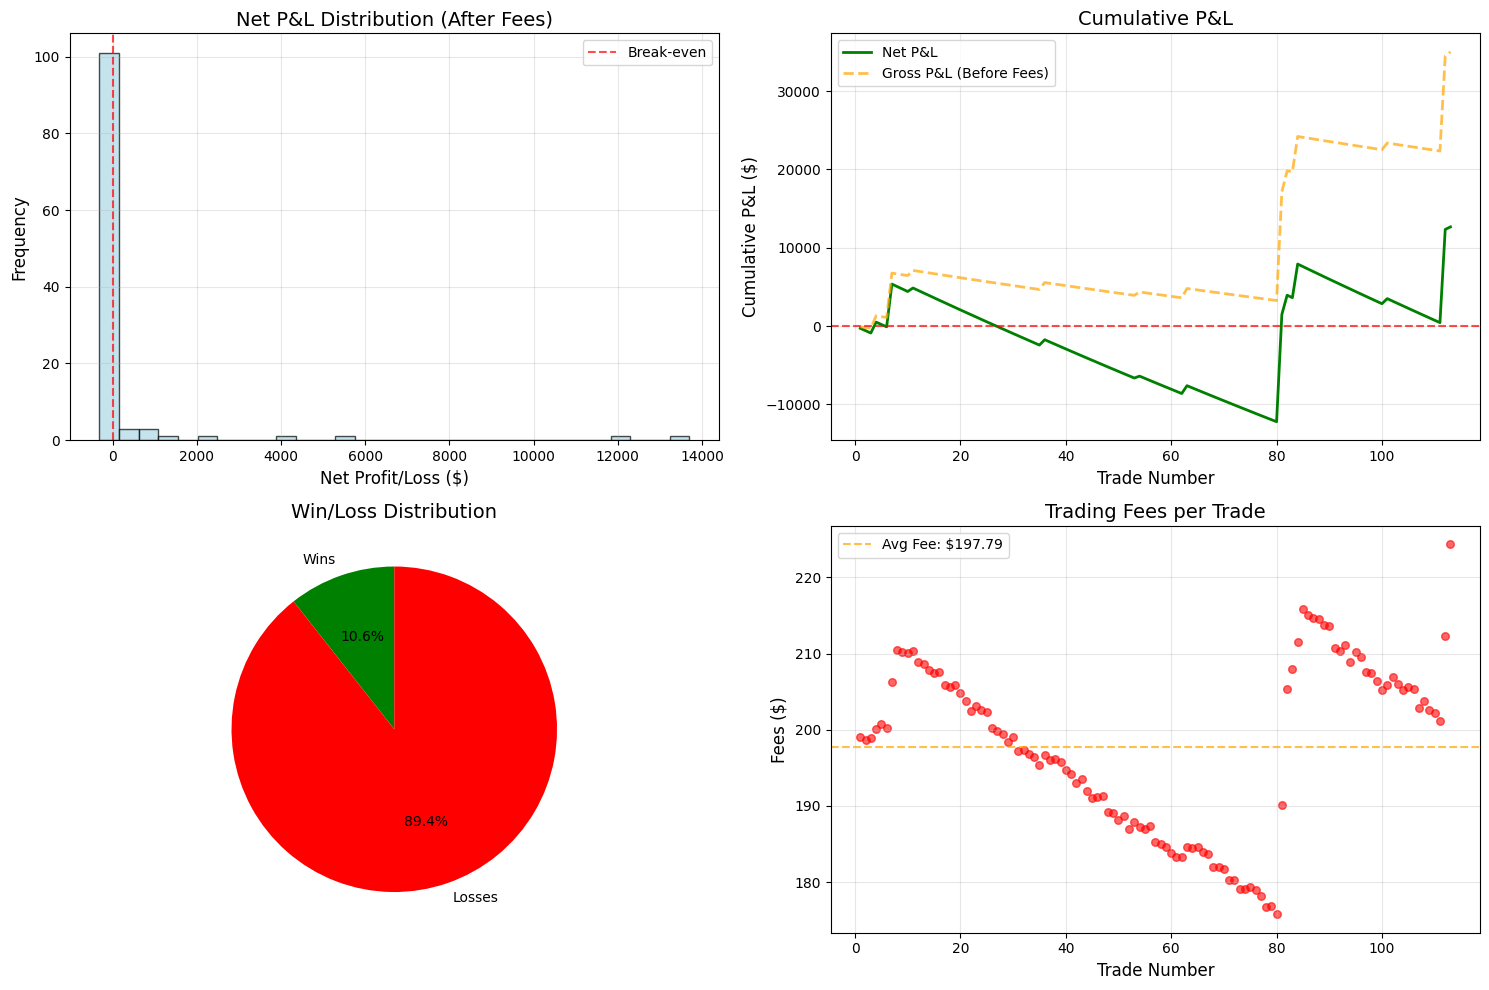


COMPREHENSIVE TRADING PERFORMANCE ANALYSIS
Total Trades: 113
Winning Trades: 12 (10.6%)

==================== FINANCIAL SUMMARY ====================
Gross P&L (Before Fees): $35007.90
Total Fees Paid: $22350.40
Net P&L (After Fees): $12657.49
Fee Impact: 63.84% of gross P&L
Average P&L: $112.01
Best Trade: $13702.63
Worst Trade: $-323.82
SMA Periods Used: 20 and 50


In [325]:
# Trading analytics using configuration constants
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_trading_analytics():
    """Plot trading analytics including fee analysis using configuration constants"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=ANALYTICS_FIGURE_SIZE)
    
    # 1. P&L Distribution (Net) using configured settings
    ax1.hist(trades_df['profit_loss'], bins=HISTOGRAM_BINS, alpha=HISTOGRAM_ALPHA, 
             color=HISTOGRAM_COLOR, edgecolor='black')
    ax1.set_title('Net P&L Distribution (After Fees)', fontsize=TITLE_FONT_SIZE)
    ax1.set_xlabel('Net Profit/Loss ($)', fontsize=LABEL_FONT_SIZE)
    ax1.set_ylabel('Frequency', fontsize=LABEL_FONT_SIZE)
    ax1.axvline(x=0, color=BEARISH_COLOR, linestyle='--', alpha=0.7, label='Break-even')
    ax1.legend()
    ax1.grid(True, alpha=GRID_ALPHA)
    
    # 2. Cumulative P&L using configured colors
    cumulative_pnl = trades_df['profit_loss'].cumsum()
    ax2.plot(range(1, len(cumulative_pnl) + 1), cumulative_pnl, 
             color=BULLISH_COLOR, linewidth=SMA_LINE_WIDTH, label='Net P&L')
    
    # Add gross P&L line if available
    if 'gross_profit_loss' in trades_df.columns:
        cumulative_gross_pnl = trades_df['gross_profit_loss'].cumsum()
        ax2.plot(range(1, len(cumulative_gross_pnl) + 1), cumulative_gross_pnl, 
                 color=SMA_20_COLOR, linewidth=SMA_LINE_WIDTH, alpha=0.7, 
                 linestyle='--', label='Gross P&L (Before Fees)')
        ax2.legend()
    
    ax2.set_title('Cumulative P&L', fontsize=TITLE_FONT_SIZE)
    ax2.set_xlabel('Trade Number', fontsize=LABEL_FONT_SIZE)
    ax2.set_ylabel('Cumulative P&L ($)', fontsize=LABEL_FONT_SIZE)
    ax2.grid(True, alpha=GRID_ALPHA)
    ax2.axhline(y=0, color=BEARISH_COLOR, linestyle='--', alpha=0.7)
    
    # 3. Win/Loss Pie Chart using configured colors
    win_count = len(trades_df[trades_df['profit_loss'] > 0])
    loss_count = len(trades_df[trades_df['profit_loss'] < 0])
    
    sizes = [win_count, loss_count]
    labels = ['Wins', 'Losses']
    colors = [BULLISH_COLOR, BEARISH_COLOR]
    
    ax3.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax3.set_title('Win/Loss Distribution', fontsize=TITLE_FONT_SIZE)
    
    # 4. Fee Impact Analysis or Monthly P&L
    if 'total_fees' in trades_df.columns:
        # Show fee impact by trade
        ax4.scatter(range(1, len(trades_df) + 1), trades_df['total_fees'], 
                   color=BEARISH_COLOR, alpha=0.6, s=30)
        ax4.set_title('Trading Fees per Trade', fontsize=TITLE_FONT_SIZE)
        ax4.set_xlabel('Trade Number', fontsize=LABEL_FONT_SIZE)
        ax4.set_ylabel('Fees ($)', fontsize=LABEL_FONT_SIZE)
        ax4.grid(True, alpha=GRID_ALPHA)
        
        # Add average fee line
        avg_fee = trades_df['total_fees'].mean()
        ax4.axhline(y=avg_fee, color=SMA_20_COLOR, linestyle='--', 
                   alpha=0.7, label=f'Avg Fee: ${avg_fee:.2f}')
        ax4.legend()
    else:
        # Fallback to monthly P&L for legacy data
        trades_df['month'] = trades_df['entry_date'].dt.to_period('M')
        monthly_pnl = trades_df.groupby('month')['profit_loss'].sum()
        
        colors = [BULLISH_COLOR if x > 0 else BEARISH_COLOR for x in monthly_pnl.values]
        bars = ax4.bar(range(len(monthly_pnl)), monthly_pnl.values, color=colors)
        ax4.set_title('Monthly P&L', fontsize=TITLE_FONT_SIZE)
        ax4.set_xlabel('Month', fontsize=LABEL_FONT_SIZE)
        ax4.set_ylabel('P&L ($)', fontsize=LABEL_FONT_SIZE)
        ax4.set_xticks(range(len(monthly_pnl)))
        ax4.set_xticklabels([str(m) for m in monthly_pnl.index], rotation=45)
        ax4.axhline(y=0, color='black', linestyle='-', alpha=GRID_ALPHA)
        ax4.grid(True, alpha=GRID_ALPHA)
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive summary statistics
    print(f"\n{'='*60}")
    print(f"COMPREHENSIVE TRADING PERFORMANCE ANALYSIS")
    print(f"{'='*60}")
    print(f"Total Trades: {len(trades_df)}")
    
    win_count = len(trades_df[trades_df['profit_loss'] > 0])
    print(f"Winning Trades: {win_count} ({win_count/len(trades_df)*100:.1f}%)")
    
    if 'total_fees' in trades_df.columns:
        total_fees = trades_df['total_fees'].sum()
        gross_pnl = trades_df['gross_profit_loss'].sum()
        net_pnl = trades_df['profit_loss'].sum()
        
        print(f"\n{'='*20} FINANCIAL SUMMARY {'='*20}")
        print(f"Gross P&L (Before Fees): ${gross_pnl:.2f}")
        print(f"Total Fees Paid: ${total_fees:.2f}")
        print(f"Net P&L (After Fees): ${net_pnl:.2f}")
        print(f"Fee Impact: {(total_fees/abs(gross_pnl)*100) if gross_pnl != 0 else 0:.2f}% of gross P&L")
    else:
        print(f"Total P&L: ${trades_df['profit_loss'].sum():.2f}")
    
    print(f"Average P&L: ${trades_df['profit_loss'].mean():.2f}")
    print(f"Best Trade: ${trades_df['profit_loss'].max():.2f}")
    print(f"Worst Trade: ${trades_df['profit_loss'].min():.2f}")
    print(f"SMA Periods Used: {SMA_SHORT_PERIOD} and {SMA_LONG_PERIOD}")

# Run the analytics
print("📊 Running comprehensive trading analytics with fee analysis...")
plot_trading_analytics()

## How to Use This Notebook

### Main Function: `visualize_trade(index)`

Use this function to visualize any specific trade. The index starts from 1.

**Examples:**
```python
# View the first trade
visualize_trade(1)

# View the 10th trade
visualize_trade(10)

# View the last trade
visualize_trade(len(trades_df))
```

### Chart Features:
- **Candlestick Chart**: Shows price action with green (up) and red (down) candles
- **SMA Lines**: Orange line for SMA20, Purple line for SMA50
- **Entry/Exit Signals**: Green/Red triangles with "ENTRY"/"EXIT" labels
- **Stop Loss**: Red dashed horizontal line
- **Volume**: Bottom chart showing trading volume
- **Trade Info**: Detailed trade statistics printed below the chart

### Navigation:
- Zoom in/out using mouse wheel
- Pan by clicking and dragging
- Hover over candles for detailed price info
- Toggle indicators on/off by clicking legend items

## Customization Guide

### 🎨 How to Customize Visualizations

All chart appearance is controlled by constants in the **Configuration Cell (Cell 2)**. Here are some examples:

#### **Quick Customization Examples:**

**Change Colors:**
```python
# Make candlesticks blue/orange instead of green/red
BULLISH_COLOR = 'blue'
BEARISH_COLOR = 'orange'

# Change SMA line colors
SMA_20_COLOR = 'cyan'
SMA_50_COLOR = 'magenta'
```

**Adjust Chart Size:**
```python
# Make charts larger
CHART_WIDTH = 20
CHART_HEIGHT = 12

# Show more candles around trades
CANDLES_BEFORE_AFTER = 15
```

**Modify SMA Periods:**
```python
# Use different SMA periods (e.g., 10 and 30)
SMA_SHORT_PERIOD = 10
SMA_LONG_PERIOD = 30
```

**Change File Paths:**
```python
# Use different data files
TRADES_DATA_PATH = '../data/result/different_backtest.csv'
PRICE_DATA_PATH = '../data/raw/ethusdt_1h.csv'
```

#### **After Making Changes:**
1. Run the Configuration Cell (Cell 2) again
2. Run the Data Loading Cell (Cell 4) again  
3. Run the SMA Calculation Cell (Cell 5) again
4. Your new settings will apply to all subsequent visualizations!

In [326]:
# Quick visualization examples
print("🚀 READY TO VISUALIZE TRADES!")
print("\nTry these commands:")
print("visualize_trade(1)  # View first trade")
print("visualize_trade(5)  # View 5th trade")
print("visualize_trade(10) # View 10th trade")
print(f"\nTotal trades available: {len(trades_df)}")

# Show first profitable trade
first_profit = trades_df[trades_df['profit_loss'] > 0].index[0] + 1
print(f"First profitable trade: #{first_profit}")

# Show largest winning trade
largest_win_idx = trades_df['profit_loss'].idxmax() + 1
print(f"Largest winning trade: #{largest_win_idx} (+${trades_df['profit_loss'].max():.2f})")

# Show largest losing trade
largest_loss_idx = trades_df['profit_loss'].idxmin() + 1
print(f"Largest losing trade: #{largest_loss_idx} ({trades_df['profit_loss'].min():.2f})")

🚀 READY TO VISUALIZE TRADES!

Try these commands:
visualize_trade(1)  # View first trade
visualize_trade(5)  # View 5th trade
visualize_trade(10) # View 10th trade

Total trades available: 113
First profitable trade: #4
Largest winning trade: #81 (+$13702.63)
Largest losing trade: #85 (-323.82)


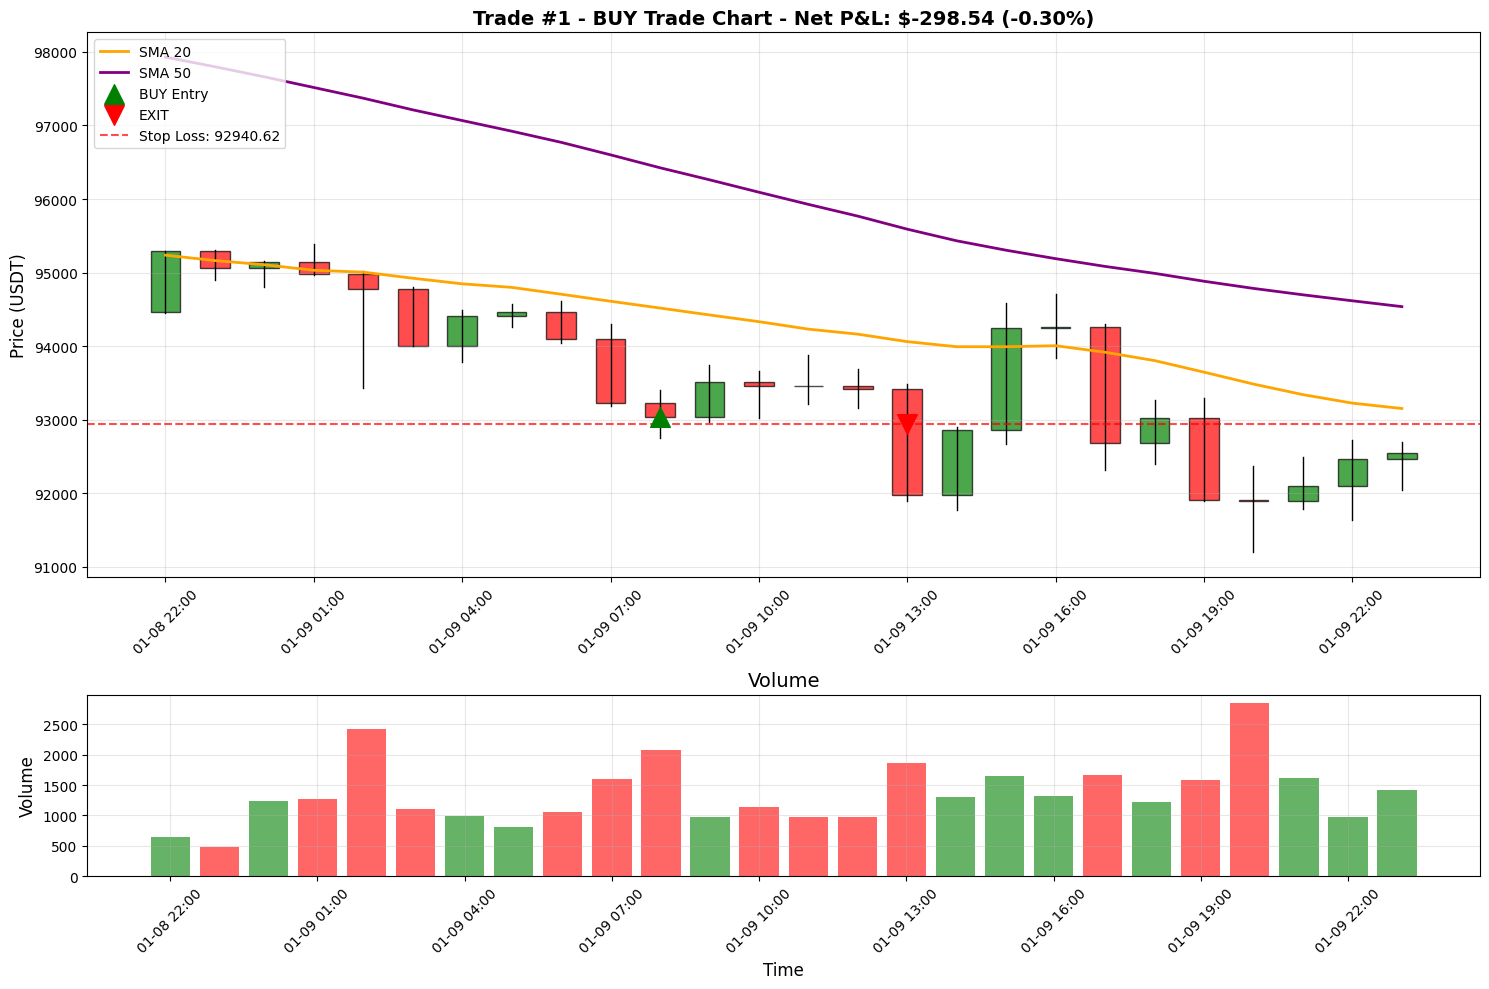


TRADE #1 DETAILS
Type: BUY
Entry: 2025-01-09 08:00:00 at $93033.65
Exit:  2025-01-09 13:00:00 at $92940.62
Duration: 0 days 05:00:00
Quantity: 1.07 BTC
Stop Loss: $92940.62
Risk Taken: $93.03
Exit Reason: stop_loss

============================== FEES ==============================
Entry Fee: $99.55
Exit Fee: $99.45
Total Fees: $198.99

========================= PROFIT/LOSS =========================
Gross P&L: $-99.55 (-0.10%)
Net P&L (After Fees): $-298.54 (-0.30%)
❌ LOSING TRADE


In [327]:
# Example: Visualize the first trade
visualize_trade(1)